<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/GAN/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [2]:
def normalize(input_image, label):
  input_image = tf.cast(input_image, tf.float32)
  input_image = input_image / 127.5 - 1
  return input_image


In [3]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite', with_info=True, as_supervised=True)
train_A , train_B = dataset['trainA'] , dataset['trainB']
test_A , test_B = dataset['testA'], dataset['testB']

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50

In [ ]:
#num_parallel_calls : 시스템의 CPU코어 여러개를 사용할수  있게끔한다.
#tf.data.experimental.AUTOTUNE : 텐서플로가 동적으로 최적의 숫자를 대신 결정한다.
#cache 변환은 데이터셋을 메모리 또는 로컬 저장소에 캐시할 수 있습니다. 이렇게하면 각 에포크 동안 실행되는 일부 작업(파일 열기 및 데이터 읽기 등)이 저장된다.
train_A = train_A.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B = train_B.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_A = test_A.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B = test_B.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
inpA = next(iter(train_A))
inpB = next(iter(train_B))

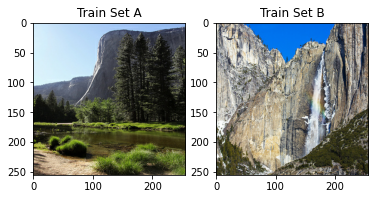

In [11]:
plt.subplot(121)
plt.title("Train Set A")
plt.imshow(inpA[0]*0.5 + 0.5)
plt.subplot(122)
plt.title("Train Set B")
plt.imshow(inpB[0]*0.5 + 0.5)

In [14]:
def downsample(filters, kernel_size=3, strides=2, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    initializer = tf.keras.initializers.random_normal(0.0, 0.02) #kernel matrix값 초기화방법
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False)) #왜 bias는 사용하지않을까?
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, kernel_size=3, strides=2, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    initializer = tf.keras.initializers.random_normal(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False)) #왜 bias는 사용하지않을까?

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
class ResnetIdentityBlock(tf.keras.Model): #tf.keras,models.Model 이랑 동일한듯.
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)

    
# (conv2d, b_n , relu * 3) or input_tensor // conv block 3번을 하거나, input_tensor을 그대로 내보내거나,
block1 = ResnetIdentityBlock(3, [512, 512, 512])
block2 = ResnetIdentityBlock(3, [512, 512, 512])
block3 = ResnetIdentityBlock(3, [512, 512, 512])


resnet = [block1, block2, block3]
print(block1(tf.zeros([1, 16, 16, 512])).shape)
print([x.name for x in block1.trainable_variables])

(1, 16, 16, 512)
['resnet_identity_block/conv2d/kernel:0', 'resnet_identity_block/conv2d/bias:0', 'resnet_identity_block/batch_normalization/gamma:0', 'resnet_identity_block/batch_normalization/beta:0', 'resnet_identity_block/conv2d_1/kernel:0', 'resnet_identity_block/conv2d_1/bias:0', 'resnet_identity_block/batch_normalization_1/gamma:0', 'resnet_identity_block/batch_normalization_1/beta:0', 'resnet_identity_block/conv2d_2/kernel:0', 'resnet_identity_block/conv2d_2/bias:0', 'resnet_identity_block/batch_normalization_2/gamma:0', 'resnet_identity_block/batch_normalization_2/beta:0']


In [18]:
#image를 받아서 재생성한 image를 출력한다. 
def build_generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4), 
        downsample(512, 4) 
    ]

    up_stack = [
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    #마지막 레이어 tanh로 끝냄
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 


    #입력 레이어 image shape 이 256, 256 , 3 
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs

    #이미지 feature map 생성.
    skips = []
    for down in down_stack:
        #Covn2D , BatchNorm, LeakyReLU
        x = down(x)
        skips.append(x)
        
    #filters = 512인 conv2d 3개 resnet block이 3개 존재.
    for block in resnet:
        x = block(x)

    skips = reversed(skips[:-1])

    #downsample block 과 , upsample block 을 skip 연결한다.
    for up, skip in zip(up_stack, skips):
        concat = tf.keras.layers.Concatenate()
        x = up(x)
        x = concat([x, skip])

    #마지막 layer 추가
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
generator = build_generator()

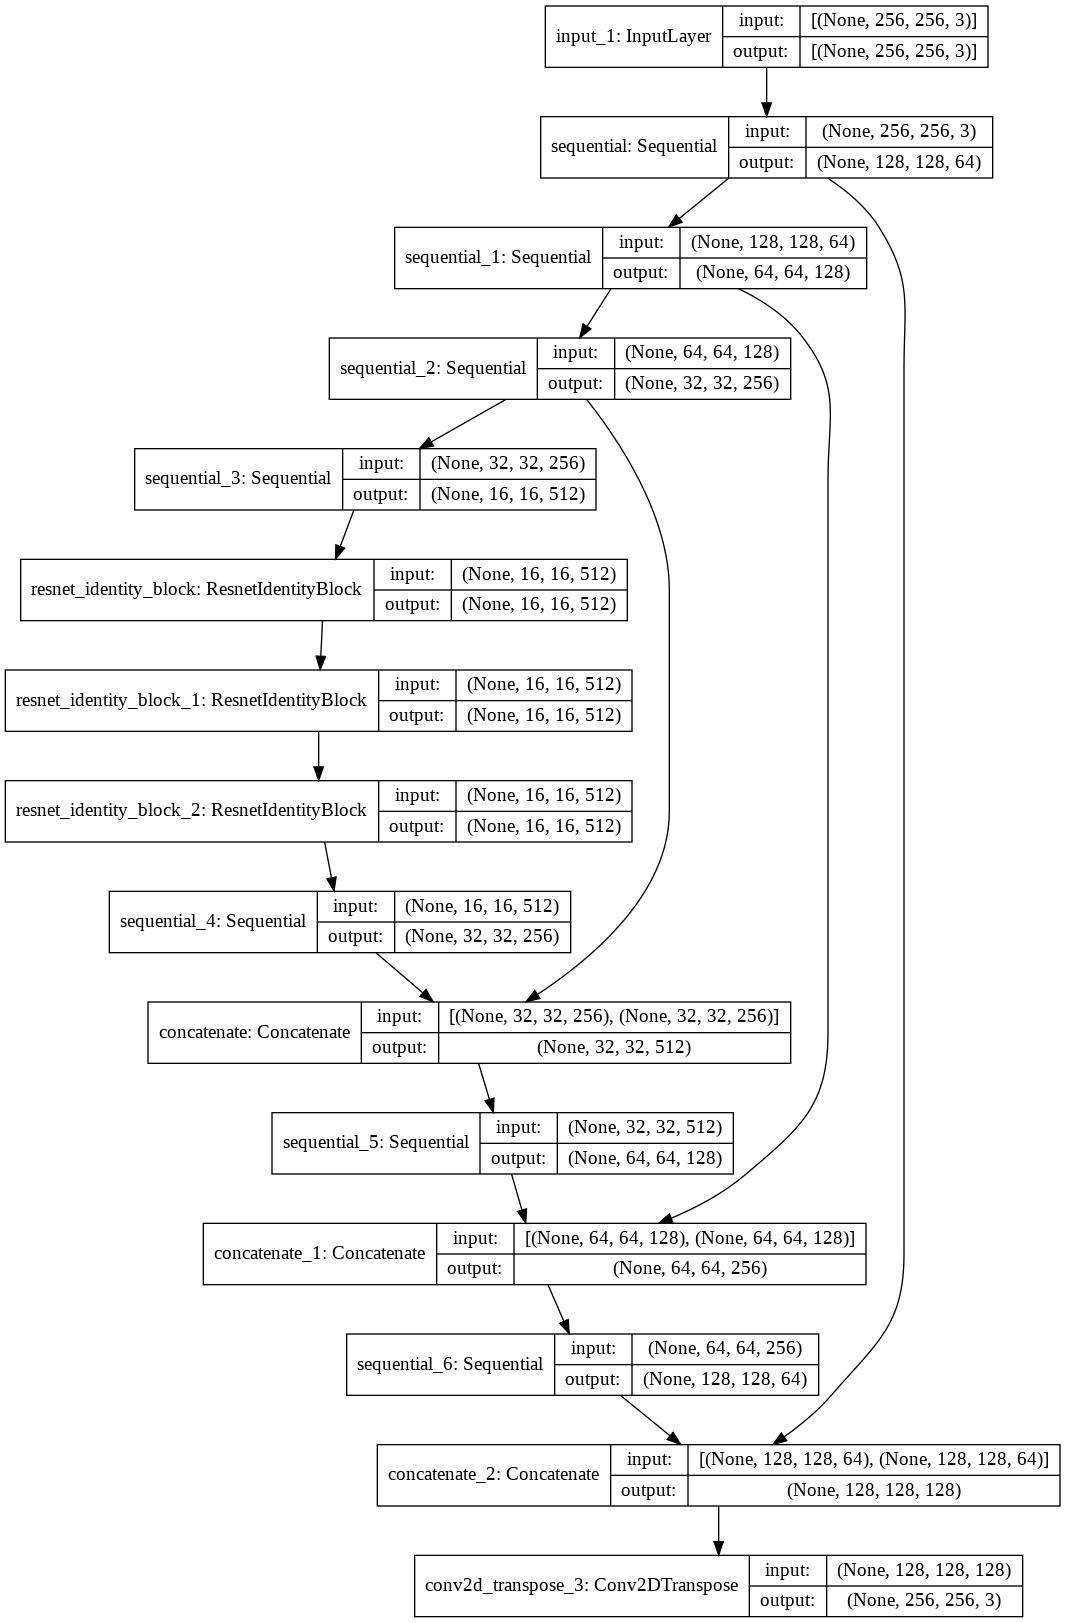

In [20]:
tf.keras.utils.plot_model(generator, 'drive/MyDrive/Colab Notebooks/models/cycle/model.png', show_shapes=True)